In [23]:
# using Pkg
# Pkg.instantiate()

using Revise
using deepHankel
using ControlSystems
using LinearAlgebra
using Plots
using LaTeXStrings
using Statistics

# Define the underlying system

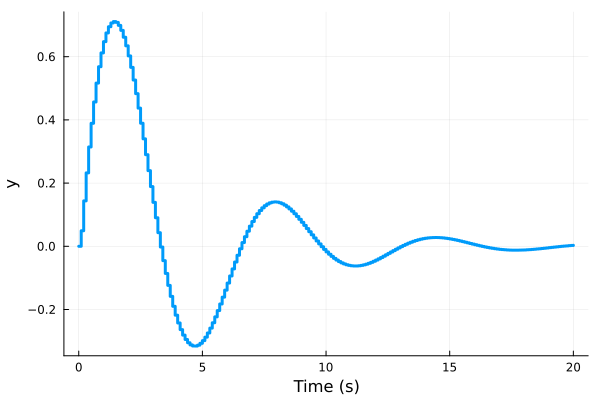

In [24]:
Ts = 0.1
s = tf("s")
z = tf("z", Ts)
P_c = 1/(s^2 + 0.5s + 1)
P = c2d(P_c,  Ts)
plot(impulse(P), lw=3)

### Gather input-output data

Assume the system starts at zero for simplicity.

We are interested in the relationship between the two matrices in the sum:
$$
\begin{bmatrix}
H_L(u) \\
H_L(y)
\end{bmatrix} \alpha +
\begin{bmatrix}
0 \\
H_L(\omega)
\end{bmatrix} \alpha
$$
Which one "wins"?

In [25]:
L = 10
N = 200
σ² = 0.1

B = behavior(P,L=L,N=N,σ²=σ²)

behavior{Float64}(TransferFunction{Discrete{Float64}, ControlSystemsBase.SisoRational{Float64}}
  0.004913614996952642z + 0.004832374721150279
-------------------------------------------------
1.0z^2 - 1.9414834347826107z + 0.9512294245007139

Sample Time: 0.1 (seconds)
Discrete-time transfer function model, [-0.6776496737228889, 0.923764852634647, -0.41553511409362215, 2.210877751574672, -0.9699233693948287, -2.3585062401577654, 1.3640477984297137, -0.4834962384633201, 0.2813995117300619, 0.5151110392272444  …  2.039499667523782, -0.9468344374430387, -1.4460930459266104, -0.9763176073296903, 0.7110737447811438, 0.11652729343617782, 1.024679164893683, 0.8470593550247544, 0.24889309355330672, 0.3399793857312497], [-0.6776496737228889, 0.923764852634647, -0.41553511409362215, 2.210877751574672, -0.9699233693948287, -2.3585062401577654, 1.3640477984297137, -0.4834962384633201, 0.2813995117300619, 0.5151110392272444  …  2.039499667523782, -0.9468344374430387, -1.4460930459266104, -0.976317

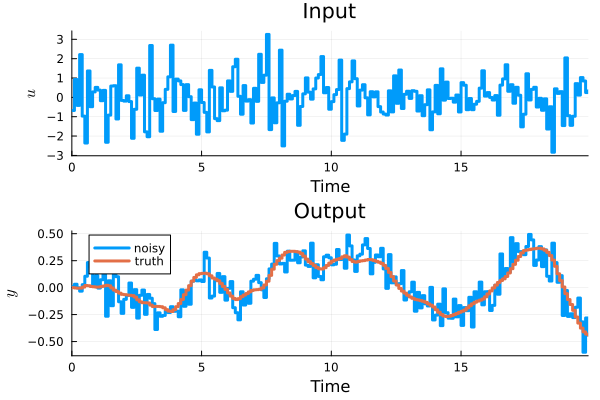

In [26]:
plt = plot( 
    xaxis  = ("Time", ),
    xlims = (0, B.t[end]),
    legend = true,
    layout = (2,1),
)
plot!(plt[1], B.t, B.u, title = "Input", ylabel = L"u", label="", linetype=:step, lw=3)
plot!(plt[2], B.t, B.y, ylabel = L"y", label="noisy", linetype=:step, lw=3)
plot!(plt[2], B.t, B.y_clean, title = "Output", ylabel = L"y", label="truth", linetype=:step, lw=3)


# Can a noisy Hankel matrix predict itself?

Use the same input data to generate a rollout with the true data matrix and noisy data matrix.
Without noise, we can generate the same input-output signal used to create the Hankel matrix in the first place.
If we dynamically generate predictions using a noisy Hankel matrix, how close do we get to the true underlying output signal?

In [27]:
true_Hankel_rollout, α_norm_true = Hankel_rollout(B.u, zeros(B.L), zeros(B.L), B.u, B.y_clean, B.L)
noisy_Hankel_rollout, α_norm = Hankel_rollout(B.u, zeros(B.L), zeros(B.L), B.u, B.y, B.L)
;


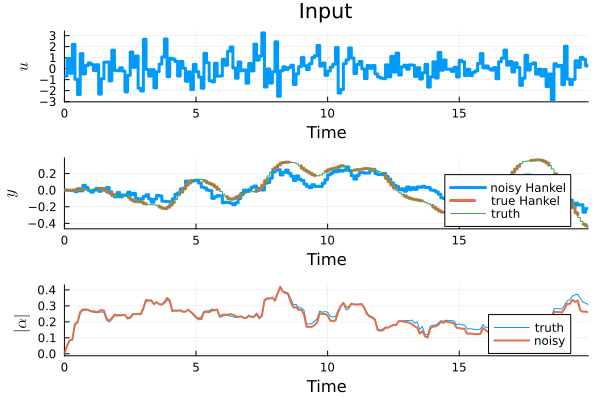

In [28]:
plt = plot( 
    xaxis  = ("Time", ),
    xlims = (0, B.t[end]),
    legend = true,
    layout = (3,1),
)
plot!(plt[1], B.t, B.u, title = "Input", ylabel = L"u", linetype=:step, label="", lw=3)
# plot!(plt[2], B.t, B.y, title = "Output", ylabel = L"y", label="noisy", linetype=:step, lw=1)
plot!(plt[2], B.t, noisy_Hankel_rollout, ylabel = L"y", label="noisy Hankel", linetype=:step, lw=3)
plot!(plt[2], B.t, true_Hankel_rollout, ylabel = L"y", label="true Hankel", linetype=:step,  ls=:dash,lw=3)
plot!(plt[2], B.t, B.y_clean, ylabel = L"y", label="truth", linetype=:step, lw=1)
plot!(plt[3], B.t, α_norm_true, ylabel = L"\left| \alpha \right|", label="truth", lw=1)
plot!(plt[3], B.t, α_norm, ylabel = L"\| \alpha \|", label="noisy", lw=2)
plot!(legend=:bottomright)


# LQR example

By sequentially applying new inputs $\hat{u}$, we can show that sequential solutions to Willems' lemma satisfy a dynamic relationship  over the trajectory space:

\begin{equation}
\left[
\begin{array}{c}
H_L(u) \\ 
H_L(y)	
\end{array}\right] \alpha'
= 
\left[
\begin{array}{c}
	H'_{L-1}(u) \\ \hline 
	0 \\ \hline
	H'_L(y)
\end{array}\right]
\alpha
+
\left[
\begin{array}{c}
0 \\ \hline
1 \\ \hline
0
\end{array}\right]
\hat{u}
=
\left[
\begin{array}{c}
\bar{u}_{0:L-2} \\ \hline
\hat{u} \\ \hline
\bar{y}'
\end{array}\right].
\end{equation}

Assuming a pseudoinverse solution at each timestep, we can solve for an optimal gain matrix using standard LQR tools, yielding the data-based controller:

$$
u = -K \left[
\begin{array}{c}
H_L(u) \\ 
H_L(y)	
\end{array}\right]^{+}
\begin{bmatrix}
\bar{u} \\
\bar{y}	
\end{bmatrix}.
$$

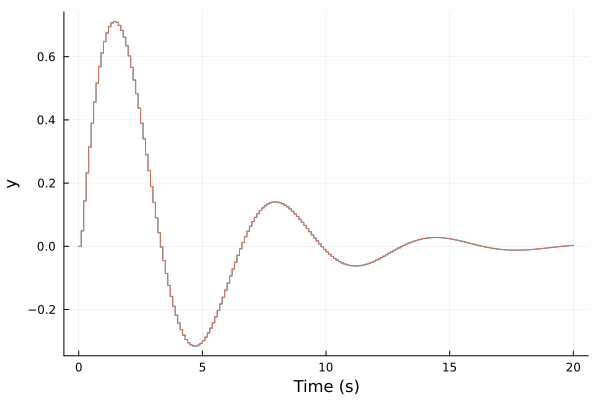

In [29]:
α_sys = Hankel_SS(B.u, B.y_clean, B.L, Ts=B.P.Ts)

plot(impulse(α_sys,20))
plot!(impulse(P,20))


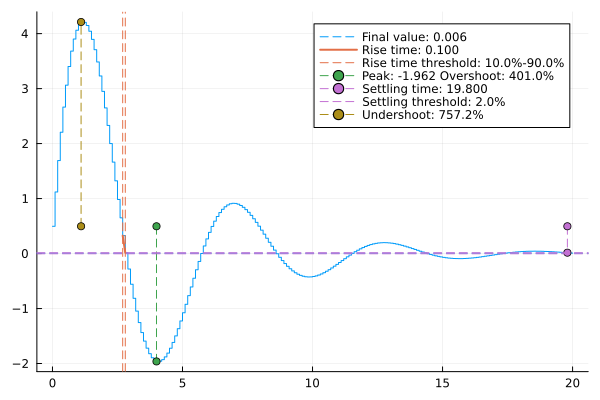

In [30]:
α_sys, α_sys_true = Hankel_SS(B)

Q̂ = α_sys.C'*I*α_sys.C # cost on the output, not the "state" α
R̂ = I

K = lqr(Discrete,α_sys.A,α_sys.B,Q̂,R̂)

u(x,t) = -K*x # Form control law
t=0:Ts:20
x0 = randn(length(K))
res = lsim(α_sys_true,u,t,x0=x0)
si = stepinfo(res)
plot(si)

### Rewriting using ``feedback``

It would be nice to fully take advantage of the `ControlSystems.jl` functionality. So we rewrite the controller shown above in state-space form. This will be useful in the following cells where we use the `feedback` method.

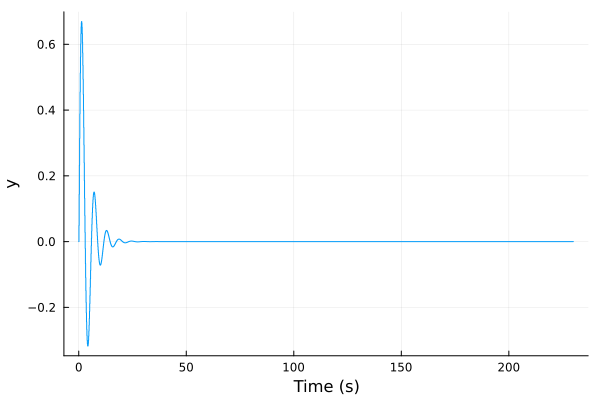

In [31]:
H_u, H_y, H_u_shift, H_y_shift = Hankel_shift(B.u,B.y,B.L)
H_pinv = pinv(vcat([H_u, H_y]...))

A_fifo, B_fifo, C_fifo = fifo_LQR(K, H_pinv, B.L)

u_LQR = ss(A_fifo, B_fifo, C_fifo, 0, Ts)

plot(impulse(feedback(P, -u_LQR)))



### Now add setpoint tracking

One can redefine the state to have the form
$$
x = 
\begin{bmatrix}
 	\alpha' - \alpha \\
 	r - y
\end{bmatrix}
$$
(rather than $x = \alpha$).
Then redefine the nominal state-space model built around $\alpha$ to include this augmented state definition.

Now, solving for the optimal gain matrix includes integral action for tracking the reference signal $r$.

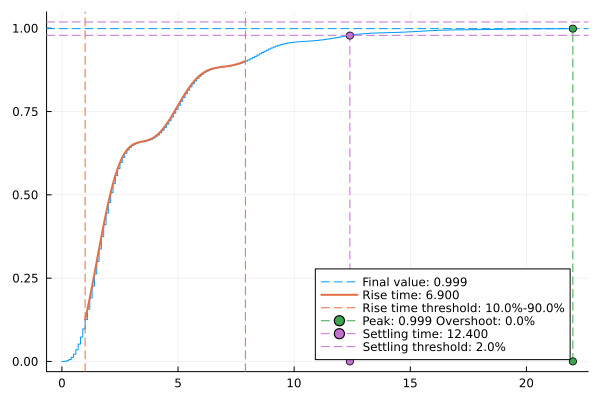

In [32]:
K = Hankel_LQR(B.u,B.y,B.L,integrator=true)
H_u, H_y, H_u_shift, H_y_shift = Hankel_shift(B.u,B.y,B.L)
H_pinv = pinv(vcat([H_u, H_y]...))

A_fifo, B_fifo, C_fifo = fifo_LQR(K[1:end-1]', H_pinv, B.L)
u_x = ss(A_fifo, B_fifo, C_fifo, 0, Ts)

cl = feedback(feedback(P,-u_x)*(-K[end]*Ts*z/(z-1)))

res = step(cl)
si = stepinfo(res)
plot(si)
